# Full Inference Pipeline
This walkthrough loads an image, runs the latest model, and generates a Grad-CAM overlay using the in-repo helper functions.

/home/yucan/.conda/envs/cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pred index: 1
logits: [-1.8254730701446533, 2.4114184379577637]
probs: [0.014246546663343906, 0.9857534170150757]


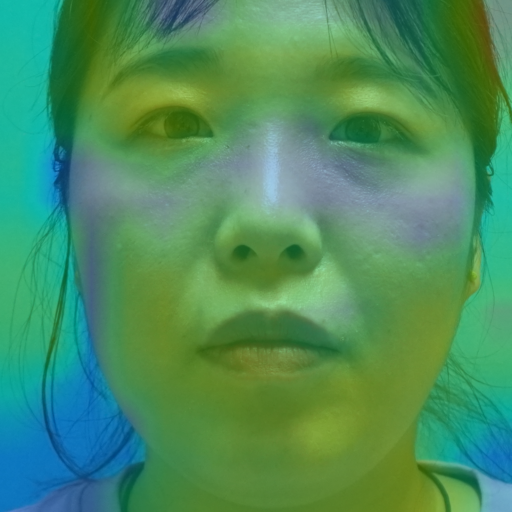

In [1]:
from pathlib import Path
from IPython.display import display
import torch
import torch.nn.functional as F
from PIL import Image
from pcos_infer import (
    GradCAMMinimal,
    _decode_resize_to01,
    _overlay_cam_on_image,
    _to_tensor,
    load_model,
 )

image_path = Path("/home/yucan/NewDisk/10Hospital/1PCOSnew/1/699/DSC02034.JPG")

# 1. Decode and prepare the network input
rgb01 = _decode_resize_to01(image_path.read_bytes())
x = _to_tensor(rgb01)

# 2. Run the classifier to obtain logits and softmax probabilities
model = load_model()
with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)
pred_index = int(torch.argmax(probs, dim=1).item())

print("pred index:", pred_index)
print("logits:", logits[0].tolist())
print("probs:", probs[0].tolist())

# 3. Build Grad-CAM for the predicted class and visualize the overlay
target_layer = getattr(model, "conv2d_7b", None) or getattr(model, "block8", None)
if target_layer is None:
    raise RuntimeError("Could not find a convolutional layer for Grad-CAM")

cam_helper = GradCAMMinimal(model, target_layer)
cam_map = cam_helper(x, target_index=pred_index)
cam_helper.remove_hooks()

overlay = Image.fromarray(_overlay_cam_on_image(rgb01, cam_map))
display(overlay)

pred: 1
probs: [0.014246546663343906, 0.9857534170150757]
logits: [-1.8254730701446533, 2.4114184379577637]


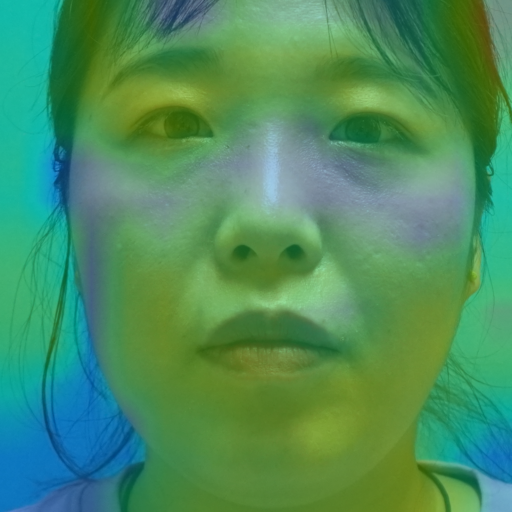

In [2]:
from pathlib import Path
from IPython.display import display
from pcos_infer import analyze_image_bytes

image_path = Path(r"/home/yucan/NewDisk/10Hospital/1PCOSnew/1/699/DSC02034.JPG")
model_weights = Path(r"/home/yucan/NewDisk/10Hospital/code/regressor/InceptionResNetV2_PCOS2nd/weights_clf/epoch006_0.00005_0.29149_0.8864.pth")

with open(image_path, "rb") as fh:
    result = analyze_image_bytes(fh.read(), make_cam=True, target_index=1)

print("pred:", result["pred"])
print("probs:", result["probs"])
print("logits:", result["logits"])
if result["overlay"] is not None:
    display(result["overlay"])

logits: [-1.8254730701446533, 2.4114184379577637]
probs: [0.014246546663343906, 0.9857534170150757]


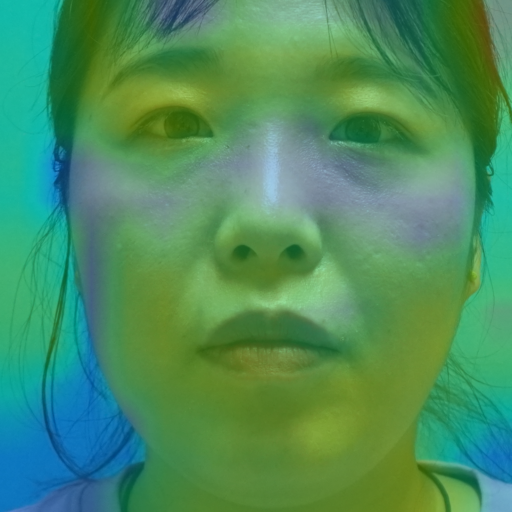

In [3]:
from pathlib import Path
from IPython.display import display
import torch
import torch.nn.functional as F
from PIL import Image
from pcos_infer import (
    GradCAMMinimal,
    _decode_resize_to01,
    _overlay_cam_on_image,
    _to_tensor,
    load_model,
 )

image_path = Path(r"/home/yucan/NewDisk/10Hospital/1PCOSnew/1/699/DSC02034.JPG")

rgb01 = _decode_resize_to01(image_path.read_bytes())
x = _to_tensor(rgb01)
model = load_model()

with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)

print("logits:", logits[0].tolist())
print("probs:", probs[0].tolist())

target_layer = getattr(model, "conv2d_7b", None) or getattr(model, "block8", None)

if target_layer is None:
    raise RuntimeError("Could not find a suitable convolutional layer for Grad-CAM")

cam_helper = GradCAMMinimal(model, target_layer)
cam_map = cam_helper(x, target_index=1)
cam_helper.remove_hooks()

overlay = Image.fromarray(_overlay_cam_on_image(rgb01, cam_map))
display(overlay)

PCOS prob: 0.6981451511383057
Predicted class: 1


(-0.5, 511.5, 511.5, -0.5)

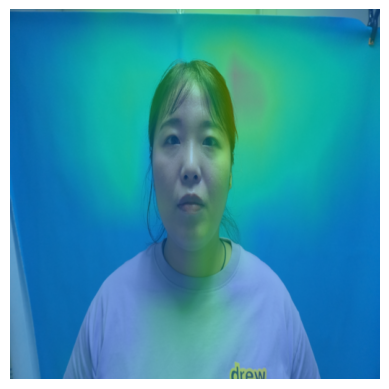

In [4]:
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from model import get_model

def _overlay_cam_on_image(rgb01: np.ndarray, cam: np.ndarray, alpha: float = 0.35) -> np.ndarray:
    cam_min, cam_max = float(cam.min()), float(cam.max())
    if cam_max - cam_min < 1e-6:
        normalized = np.zeros_like(cam)
    else:
        normalized = (cam - cam_min) / (cam_max - cam_min)
    r = np.clip(1.5 * normalized - 0.5, 0.0, 1.0)
    g = np.clip(1.5 - np.abs(2.0 * normalized - 1.0), 0.0, 1.0)
    b = np.clip(1.5 * (1.0 - normalized) - 0.5, 0.0, 1.0)
    heatmap = np.stack([r, g, b], axis=-1)
    blended = heatmap * alpha + rgb01 * (1.0 - alpha)
    return np.clip(blended, 0.0, 1.0)

image_path = Path(r"/home/yucan/NewDisk/10Hospital/1PCOSnew/1/699/DSC02034.JPG")
model_path = Path(r"/home/yucan/NewDisk/10Hospital/code/regressor/InceptionResNetV2_PCOS2nd/weights_clf/epoch006_0.00005_0.29149_0.8864.pth")

image = Image.open(image_path).convert("RGB").resize((512, 512), Image.BILINEAR)
rgb01 = np.asarray(image, dtype=np.float32) / 255.0
input_tensor = torch.from_numpy(rgb01).permute(2, 0, 1).unsqueeze(0)

model = get_model("InceptionResNetV2")
state = torch.load(model_path, map_location="cpu")
model.load_state_dict(state)
model.eval()

with torch.no_grad():
    logits = model(input_tensor)
    probabilities = F.softmax(logits, dim=1)
    print("PCOS prob:", float(probabilities[0, 1]))
    print("Predicted class:", int(torch.argmax(probabilities, dim=1)))

target_layers = [model.conv2d_7b]
with GradCAM(model=model, target_layers=target_layers,) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])[0]

overlay = _overlay_cam_on_image(rgb01, grayscale_cam)
plt.imshow(overlay)
plt.axis("off")

Predicted: PCOS (PCOS probability = 0.977)


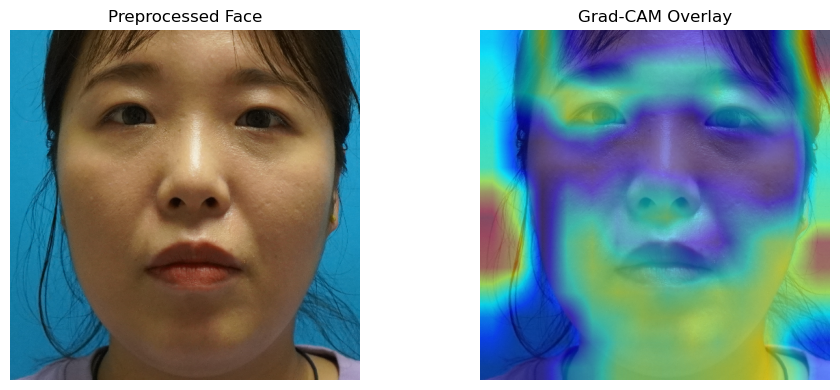

In [5]:
import functools
from pathlib import Path
from typing import Dict, Optional
import cv2
import dlib
import numpy as np
import torch
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from model import get_model
import matplotlib.pyplot as plt

def _detect_primary_face(detector: dlib.fhog_object_detector, image_rgb: np.ndarray) -> Optional[np.ndarray]:
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)
    if not faces:
        return None
    largest = max(faces, key=lambda f: f.width() * f.height())
    x, y, w, h = largest.left(), largest.top(), largest.width(), largest.height()
    x0, y0 = max(x, 0), max(y, 0)
    x1, y1 = min(x0 + w, image_rgb.shape[1]), min(y0 + h, image_rgb.shape[0])
    if x1 <= x0 or y1 <= y0:
        return None
    return image_rgb[y0:y1, x0:x1]

@functools.lru_cache(maxsize=1)
def _load_model(model_path: str, device_str: str):
    model = get_model("InceptionResNetV2")
    state = torch.load(model_path, map_location=device_str)
    model.load_state_dict(state)
    model.to(device_str)
    model.eval()
    return model

def analyze_pcos_image(image_path: str, model_path: str, device: Optional[str] = None) -> Dict[str, object]:
    image_file = Path(image_path)
    if not image_file.exists():
        raise FileNotFoundError(f"Image not found: {image_file}")
    raw = cv2.imdecode(np.fromfile(str(image_file), dtype=np.uint8), cv2.IMREAD_COLOR)
    if raw is None:
        raise ValueError(f"Unable to read image: {image_file}")
    image_rgb = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    detector = dlib.get_frontal_face_detector()
    face = _detect_primary_face(detector, image_rgb)
    if face is None:
        face = image_rgb
    face = face.astype(np.float32) / 255.0
    face_resized = cv2.resize(face, (512, 512), interpolation=cv2.INTER_LINEAR)
    preprocess = transforms.Compose([transforms.ToTensor()])
    image_tensor = preprocess(face_resized).unsqueeze(0)
    device_str = device or ("cuda" if torch.cuda.is_available() else "cpu")
    torch_device = torch.device(device_str)
    model = _load_model(model_path, device_str)
    input_tensor = image_tensor.to(torch_device)
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1)
    pcos_prob = float(probabilities[0, 1].cpu())
    prediction = "PCOS" if pcos_prob >= 0.5 else "Non-PCOS"
    target_layers = [model.conv2d_7b]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(
            input_tensor=input_tensor,
            targets=[ClassifierOutputTarget(1)]
)
        grayscale_cam = grayscale_cam[0]
    overlay = show_cam_on_image(face_resized, grayscale_cam, use_rgb=True)
    return {
        "probability": pcos_prob,
        "prediction": prediction,
        "overlay": overlay,
        "face": face_resized,
    }

example_image = r"/home/yucan/NewDisk/10Hospital/1PCOSnew/1/699/DSC02034.JPG"
model_weights = r"/home/yucan/NewDisk/10Hospital/code/regressor/InceptionResNetV2_PCOS2nd/weights_clf/epoch006_0.00005_0.29149_0.8864.pth"
result = analyze_pcos_image(example_image, model_weights)
print(f"Predicted: {result['prediction']} (PCOS probability = {result['probability']:.3f})")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(result["face"])
axes[0].set_title("Preprocessed Face")
axes[0].axis("off")
axes[1].imshow(result["overlay"])
axes[1].set_title("Grad-CAM Overlay")
axes[1].axis("off")
plt.tight_layout()
plt.show()

Notebook pred: 1
Notebook probs: [0.014246546663343906, 0.9857534170150757]
Notebook logits: [-1.8254730701446533, 2.4114184379577637]


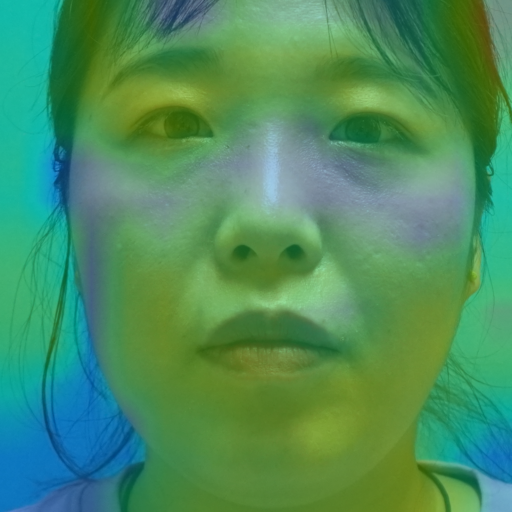

In [6]:
from pathlib import Path
import io
import logging
from typing import Dict, Optional
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import get_model

try:
    import cv2
    import dlib
except ImportError:
    cv2 = None
    dlib = None

LOGGER = logging.getLogger("pcos_infer_notebook")
WEIGHTS_PATH = Path("/home/yucan/NewDisk/10Hospital/code/regressor/InceptionResNetV2_PCOS2nd/weights_clf/epoch006_0.00005_0.29149_0.8864.pth")
INPUT_SIZE = (512, 512)

def _overlay_cam_on_image_nb(rgb01: np.ndarray, cam01: np.ndarray, alpha: float = 0.35) -> np.ndarray:
    cam = np.clip(cam01, 0.0, 1.0)
    r = np.clip(1.5 * cam - 0.5, 0.0, 1.0)
    g = np.clip(1.5 - np.abs(2 * cam - 1.0), 0.0, 1.0)
    b = np.clip(1.5 * (1 - cam) - 0.5, 0.0, 1.0)
    heatmap = np.stack([r, g, b], axis=-1)
    out = heatmap * alpha + np.clip(rgb01, 0.0, 1.0) * (1 - alpha)
    return (np.clip(out, 0.0, 1.0) * 255).astype(np.uint8)

def _detect_primary_face_nb(image_rgb: np.ndarray) -> Optional[np.ndarray]:
    if cv2 is None or dlib is None:
        return None
    detector = dlib.get_frontal_face_detector()
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)
    if not faces:
        return None
    largest = max(faces, key=lambda f: f.width() * f.height())
    x, y, w, h = largest.left(), largest.top(), largest.width(), largest.height()
    x0, y0 = max(x, 0), max(y, 0)
    x1 = min(x0 + w, image_rgb.shape[1])
    y1 = min(y0 + h, image_rgb.shape[0])
    if x1 <= x0 or y1 <= y0:
        return None
    return image_rgb[y0:y1, x0:x1]

def _decode_resize_to01_nb(img_bytes: bytes, size_hw=INPUT_SIZE) -> np.ndarray:
    image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    rgb = np.asarray(image, dtype=np.uint8)
    face = _detect_primary_face_nb(rgb)
    if face is None:
        if cv2 is None or dlib is None:
            LOGGER.debug("Face detection skipped (cv2/dlib unavailable); using full frame.")
        else:
            LOGGER.debug("Face detector returned no faces; using full frame.")
        face = rgb
    resized = Image.fromarray(face).resize(size_hw, Image.BILINEAR)
    return np.asarray(resized, dtype=np.float32) / 255.0

def _to_tensor_nb(rgb01: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(rgb01).permute(2, 0, 1).unsqueeze(0).float()

class GradCAMMinimalNB:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations: Optional[torch.Tensor] = None
        self.gradients: Optional[torch.Tensor] = None
        self._forward_handle = target_layer.register_forward_hook(self._forward_hook)
        try:
            self._backward_handle = target_layer.register_full_backward_hook(self._backward_hook)
        except AttributeError:
            self._backward_handle = target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, _module, _inp, output):
        self.activations = output.detach()

    def _backward_hook(self, _module, _grad_input, grad_output):
        grad = grad_output[0] if isinstance(grad_output, (tuple, list)) else grad_output
        self.gradients = grad.detach()

    def remove_hooks(self) -> None:
        self._forward_handle.remove()
        self._backward_handle.remove()

    def _normalize_cam(self, cam: torch.Tensor) -> np.ndarray:
        cam = cam - cam.min()
        maxv = cam.max()
        if float(maxv) > 0:
            cam = cam / maxv
        return cam.cpu().numpy()

    def __call__(self, x: torch.Tensor, target_index: Optional[int] = None) -> np.ndarray:
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        if target_index is None:
            target_index = int(torch.argmax(logits, dim=1).item())
        loss = logits[:, target_index].sum()
        loss.backward()
        if self.activations is None or self.gradients is None:
            raise RuntimeError("Grad-CAM hooks did not capture activations/gradients")
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = cam[0, 0]
        return self._normalize_cam(cam)

_model_cache_nb: Optional[nn.Module] = None

def load_model_nb() -> nn.Module:
    global _model_cache_nb
    if _model_cache_nb is not None:
        return _model_cache_nb
    torch.set_num_threads(1)
    model = get_model("InceptionResNetV2")
    state = torch.load(WEIGHTS_PATH, map_location="cpu")
    model.load_state_dict(state, strict=True)
    model.eval()
    _model_cache_nb = model
    return model

def predict_nb(rgb01: np.ndarray):
    model = load_model_nb()
    x = _to_tensor_nb(rgb01)
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    pred = int(torch.argmax(probs, dim=1).item())
    return logits[0].tolist(), probs[0].tolist(), pred

def analyze_image_bytes_nb(img_bytes: bytes, make_cam: bool = True, target_index: int = 1) -> Dict[str, object]:
    rgb01 = _decode_resize_to01_nb(img_bytes, size_hw=INPUT_SIZE)
    logits, probs, pred = predict_nb(rgb01)

    overlay_img = None
    if make_cam:
        model = load_model_nb()
        if hasattr(model, "conv2d_7b"):
            target_layer = getattr(model, "conv2d_7b")
        elif hasattr(model, "block8"):
            target_layer = getattr(model, "block8")
        else:
            target_layer = next((m for m in reversed(list(model.modules())) if isinstance(m, nn.Conv2d)), None)
        if target_layer is not None:
            cam_helper = GradCAMMinimalNB(model, target_layer)
            cam_map = cam_helper(_to_tensor_nb(rgb01), target_index=target_index)
            cam_helper.remove_hooks()
            overlay_img = Image.fromarray(_overlay_cam_on_image_nb(rgb01, cam_map))

    return {
        "pred": pred,
        "probs": probs,
        "logits": logits,
        "overlay": overlay_img,
    }

with open(Path("/home/yucan/NewDisk/10Hospital/1PCOSnew/1/699/DSC02034.JPG"), "rb") as fh:
    notebook_result = analyze_image_bytes_nb(fh.read(), make_cam=True, target_index=1)

print("Notebook pred:", notebook_result["pred"])
print("Notebook probs:", notebook_result["probs"])
print("Notebook logits:", notebook_result["logits"])
if notebook_result["overlay"] is not None:
    display(notebook_result["overlay"])